## Artificial Neural Network to model specific mass balance

In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from google.colab import files

In [ ]:
# Load drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Read dataframe
data = pd.read_csv('/content/drive/MyDrive/ADS_thesis/df2000_2020_imp.csv')
data = data.drop(['O2Region','Unnamed: 0','dhdt','dmdt'],axis=1)
labels=data['dmdtda']

#based on RF and XGBoost importances:
features = data[['prcp_mean_2000_2020','Slope','Zmed','temp_mean_2000_2020',
                 'temp_diff_2000_2020','prcp_diff_1980_2000','temp_diff_1980-2000',
                 'prcp_diff_2000_2020','debris_area_ela_p','tstar_aar','velocity_mean']]

# Z-score the independent numerical variables
X=features
y=np.ravel(labels)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2,random_state=32389) 

## Run Artificial Neural Network model with TensorFlow API

In [ ]:
# Make run determistic
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Configure model architecture
input = tf.keras.layers.Input((11,))

x = tf.keras.layers.Dense(150, activation=tf.nn.leaky_relu)(input)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(50, activation=tf.nn.leaky_relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(50, activation=tf.nn.leaky_relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(50, activation=tf.nn.leaky_relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

# Run model
history = model.fit(xtrain, ytrain, batch_size=64,epochs=2000, verbose=2, validation_split=0.1)


Epoch 1/2000
92/92 - 3s - loss: 0.2106 - mse: 0.0808 - val_loss: 0.1859 - val_mse: 0.0752 - 3s/epoch - 32ms/step
Epoch 2/2000
92/92 - 1s - loss: 0.1942 - mse: 0.0708 - val_loss: 0.1809 - val_mse: 0.0708 - 595ms/epoch - 6ms/step
Epoch 3/2000
92/92 - 1s - loss: 0.1862 - mse: 0.0654 - val_loss: 0.1746 - val_mse: 0.0684 - 590ms/epoch - 6ms/step
Epoch 4/2000
92/92 - 1s - loss: 0.1821 - mse: 0.0624 - val_loss: 0.1690 - val_mse: 0.0623 - 563ms/epoch - 6ms/step
Epoch 5/2000
92/92 - 1s - loss: 0.1793 - mse: 0.0600 - val_loss: 0.1677 - val_mse: 0.0635 - 582ms/epoch - 6ms/step
Epoch 6/2000
92/92 - 1s - loss: 0.1766 - mse: 0.0589 - val_loss: 0.1635 - val_mse: 0.0626 - 588ms/epoch - 6ms/step
Epoch 7/2000
92/92 - 1s - loss: 0.1718 - mse: 0.0565 - val_loss: 0.1606 - val_mse: 0.0575 - 592ms/epoch - 6ms/step
Epoch 8/2000
92/92 - 1s - loss: 0.1708 - mse: 0.0553 - val_loss: 0.1603 - val_mse: 0.0584 - 616ms/epoch - 7ms/step
Epoch 9/2000
92/92 - 1s - loss: 0.1678 - mse: 0.0535 - val_loss: 0.1576 - val_mse:

## Make predictions with trained model

In [ ]:
ypred = model.predict(xtest)
ypred = np.squeeze(ypred)
print(model.evaluate(xtrain, ytrain))

mae = np.mean(abs(ypred - ytest))
rmse = mean_squared_error(ytest, ypred, squared=False)
r2 = metrics.r2_score(ytest, ypred) #Rsquared

# Print out the mean absolute error (mae), RMSE, R2
print('MAE:',mae)
print('RMSE', rmse)
print('R2:',r2)

In [ ]:
# Print the model architecture
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 150)               1800      
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

## Predicted vs Actual plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

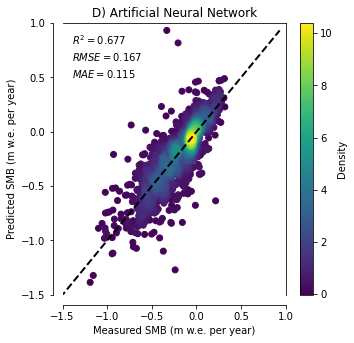

In [ ]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(5,5))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.scatter(x, y, c=z, **kwargs )
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([-1.5,1])
    ax.set_ylim([-1.5,1])
    ax.set_xlabel("Measured SMB (m w.e. per year)")
    ax.set_ylabel("Predicted SMB (m w.e. per year)")
    ax.annotate("$R^2={:.3f}$".format(r2), (-1.4, 0.8))
    ax.annotate("$RMSE={:.3f}$".format(rmse), (-1.4, 0.65))
    ax.annotate("$MAE={:.3f}$".format(mae), (-1.4, 0.5))
    plt.title("D) Artificial Neural Network")
    ax.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "--k", linewidth=2)
    
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.savefig('deep_learning.png', bbox_inches='tight', dpi=300)
    files.download('deep_learning.png')


    return ax


if "__main__" == __name__ :
    density_scatter(ypred, ytest, bins = [30,30] )
